
We are go to extract feature from query image and all the image in the base.

we will calculate entropy, roberts, sobel, gabor and average value of all pixal.

Feature from every image in the input folder are captured in a hdf5 file.


In [76]:
import numpy as np 
import os
from skimage.transform import resize
from skimage import io, img_as_ubyte
import h5py
from skimage.filters import roberts, sobel
from skimage.color import rgb2lab, rgb2gray
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [77]:
def extract_features(image):
    #extracts color features
    lab_image = rgb2lab(image)
    A_image = lab_image[:,:,1]
    A_feat = A_image.mean()
    B_image = lab_image[:,:,2]
    B_feat = B_image.mean()

    #extracts textural features on the gray image
    gray_image = rgb2gray(image)
    gray_image = resize(gray_image, (256,256))
    gray_image = img_as_ubyte(gray_image)

    #entropy
    entropy_image = entropy(gray_image, disk(3))
    entropy_mean = entropy_image.mean()
    entropy_std = entropy_image.std()
    roberts_image = roberts(gray_image)
    robert_mean = roberts_image.mean()
    sobel_image = sobel(gray_image)
    sobel_mean = sobel_image.mean()

    #Gabor1
    kernel1 = cv2.getGaborKernel((9, 9), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_32F)
    gabor1 = (cv2.filter2D(gray_image, cv2.CV_8UC3, kernel1)).mean()

    #Gabor 2
    kernel2 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/4, 0.9, 0, ktype=cv2.CV_32F)
    gabor2 = (cv2.filter2D(gray_image, cv2.CV_8UC3, kernel2)).mean()

    #Gabor 3
    kernel3 = cv2.getGaborKernel((9, 9), 5, np.pi/2, np.pi/2, 0.1, 0, ktype=cv2.CV_32F)
    gabor3 = (cv2.filter2D(gray_image, cv2.CV_8UC3, kernel3)).mean()
    custom_features = np.array([A_feat, B_feat, entropy_mean, entropy_std, robert_mean, sobel_mean, gabor1, gabor2, gabor3])

    return custom_features

if __name__ == "__main__":
    path = "/Users/sudipkhadka/Desktop/mlop/semantic_search/images/"

    feats = []
    names = []

    for img in os.listdir(path):
        print("Extracting features from image: ", img)
        #image = io.imread(path+img)
        image = io.imread(os.path.join(path, img))

        X = extract_features(image)
        feats.append(X)
        names.append(img)
    feats = np.array(feats)
    feature_file = "CustomFeatures.h5"
    print("Saving features to h5 file")

    h5f = h5py.File(feature_file, "w")
    h5f.create_dataset('dataset_1', data = feats)
    h5f.create_dataset('dataset_2', data = np.string_(names))
    h5f.close()


Extracting features from image:  5afd80bec1.jpg
Extracting features from image:  2a40de8365.jpg
Extracting features from image:  2a242797a3.jpg
Extracting features from image:  2dd74b37fe.jpg
Extracting features from image:  1ebb88dff2.jpg
Extracting features from image:  0f72117666.jpg
Extracting features from image:  1a993de5a8.jpg
Extracting features from image:  4c273d12a9.jpg
Extracting features from image:  1cb123c4e9.jpg
Extracting features from image:  6b36a20a5a.jpg
Extracting features from image:  1d556456dc.jpg
Extracting features from image:  2c52b24385.jpg
Extracting features from image:  0b688923b0.jpg
Saving features to h5 file


**Query using our custom features**

In [92]:
import numpy as np
import h5py
from skimage import io
from scipy import spatial

In [93]:
h5f_file = h5py.File("CustomFeatures.h5", 'r')
feats = h5f_file['dataset_1'][:]
image_name = h5f_file['dataset_2'][:]
h5f_file.close()

In [94]:
image_directory = '/Users/sudipkhadka/Desktop/mlop/semantic_search/images'
query_image = io.imread("/Users/sudipkhadka/Desktop/mlop/semantic_search/images/2a40de8365.jpg")
print("searching for similar image name")

X = extract_features(query_image)
scores = []
for i in range(feats.shape[0]):
    score = 1 - spatial.distance.cosine(X, feats[i])
    scores.append(score)
scores = np.array(scores)
rank_id = np.argsort(scores)[::-1]
rank_score = scores[rank_id]

max_num_matches = 4
lists = [image_name[index] for i, index in enumerate(rank_id[0:max_num_matches])]
print("top %d images in order are:" % max_num_matches, lists)


searching for similar image name
top 4 images in order are: [b'2a40de8365.jpg', b'4c273d12a9.jpg', b'6b36a20a5a.jpg', b'1a993de5a8.jpg']


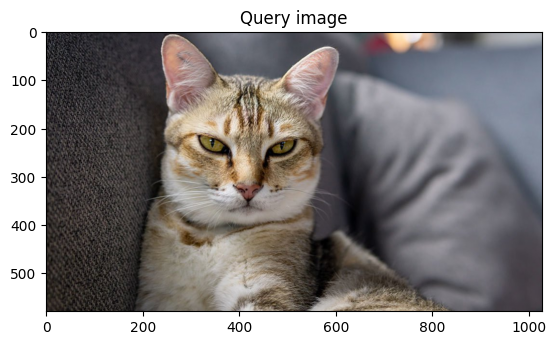

In [95]:
plt.imshow(query_image)
plt.title('Query image')
plt.show()

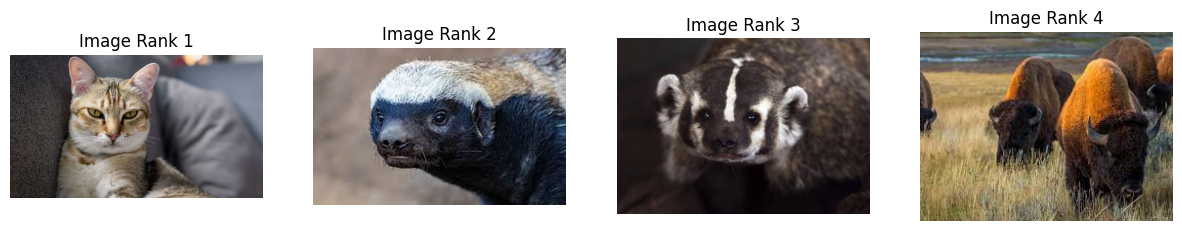

In [96]:
lists = [os.path.join(image_directory, image_name[index].decode('utf-8')) if isinstance(image_name[index], bytes) else os.path.join(image_directory, image_name[index]) 
         for i, index in enumerate(rank_id[0:max_num_matches])]

num_images = len(lists)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, image_path in enumerate(lists):
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)  
        axes[i].imshow(img)  
        axes[i].axis('off')  
        axes[i].set_title(f"Image Rank {i+1}")
    else:
        print(f"File not found: {image_path}") 
plt.show()